- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/26.
- **Propósito del código:** Transformaciones y primer modelo regresión logística.  
- **Autor(es):** Francisco Pastor.  
- **Descripción y uso:** Ejecutar para ver resultado de modelo regresión logística en P2.
- **Estado actual:** En revisión.


# REGRESIÓN LOGÍSTICA

In [2]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..", "data", "processed","train.parquet")
df_train= pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2000-06-09,Kevin Randleman,Pedro Rizzo,False,0.0,0.8,0.279,0.315,0.770,0.000,...,0.0,0.0,0.8,0.0,-0.8,-0.036,0.615385,1.0,0.0,526.0
1,2000-09-22,Jeremy Horn,Eugene Jackson,False,0.0,0.5,0.696,0.550,0.084,0.000,...,0.0,0.5,0.0,0.0,-0.5,0.146,0.250000,0.4,0.0,3.3
2,2001-02-23,Tito Ortiz,Evan Tanner,False,0.3,0.0,0.552,0.741,0.874,1.000,...,0.0,0.0,0.0,0.0,0.3,-0.189,0.178571,-0.1,0.0,458.1
3,2001-05-04,Chuck Liddell,Kevin Randleman,False,0.0,0.0,0.508,0.532,0.000,0.758,...,1.0,0.0,0.0,1.0,0.0,-0.024,-0.518519,-1.5,0.2,-455.0
4,2001-06-29,Pat Miletich,Shonie Carter,False,0.0,1.0,0.451,0.521,0.500,0.646,...,0.5,0.0,0.0,0.0,-1.0,-0.070,0.037945,0.8,-1.2,-137.3


In [4]:
ruta_test =  os.path.join("..","..", "data", "processed","test.parquet")
df_test= pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-04-22,Rani Yahya,Montel Jackson,True,0.0,2.1,0.569,0.513,0.415,0.240,...,0.0,0.0,5.0,2.0,-2.1,0.056,0.047222,0.5,0.7,140.0
1,2023-04-22,Jeremiah Wells,Matthew Semelsberger,False,0.7,1.8,0.529,0.382,0.060,0.800,...,0.0,0.0,0.0,1.8,-1.1,0.147,-0.403226,0.3,0.0,-111.5
2,2023-04-29,Caio Borralho,Michal Oleksiejczuk,False,0.0,0.6,0.565,0.510,0.690,0.100,...,0.0,2.0,0.0,1.0,-0.6,0.055,0.370656,1.0,1.2,414.4
3,2023-04-29,Song Yadong,Ricky Simon,False,0.5,0.8,0.379,0.595,0.500,0.407,...,0.0,0.0,1.0,1.0,-0.3,-0.216,0.150000,-0.7,0.0,-244.9
4,2023-04-29,Rodolfo Vieira,Cody Brundage,False,0.0,0.3,0.528,0.214,0.305,0.700,...,1.0,0.0,0.5,1.0,-0.3,0.314,-0.393102,0.1,0.0,62.6


In [5]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.618167
True     0.381833
Name: proportion, dtype: float64

In [6]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.551724
True     0.448276
Name: proportion, dtype: float64

En esta celda se define la función aplicarRFECV, que realiza selección automática de variables mediante RFECV (Recursive Feature Elimination con validación cruzada). Se utiliza regresión logística como estimador y TimeSeriesSplit para mantener el balance de clases en los folds. Este proceso elimina iterativamente las variables menos útiles, mejorando la generalización del modelo al quedarse solo con las más relevantes.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

def aplicarRFECV(X, y):
    MIN_FEATURES = 5
    METRICA = "balanced_accuracy"

    # Pipeline con escalado + regresión logística
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('clf', LogisticRegression(max_iter=5000, class_weight="balanced"))
    ])

    # Validación cruzada temporal
    cv = TimeSeriesSplit(n_splits=5)

    # RFECV con importancia desde el coef_ del modelo
    rfecv = RFECV(
        estimator=pipeline,
        step=1,
        cv=cv,
        scoring=METRICA,
        min_features_to_select=MIN_FEATURES,
        importance_getter=lambda est: est.named_steps["clf"].coef_,
        n_jobs=-1
    )

    # Ajustar
    rfecv.fit(X, y)

    # Obtener variables seleccionadas
    num_optimal_features = rfecv.n_features_
    print("Número óptimo de variables seleccionadas:", num_optimal_features)

    selected_feature_indices = rfecv.support_
    selected_feature_names = [X.columns[i] for i, selected in enumerate(selected_feature_indices) if selected]

    # Graficar evolución
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(12, 6))
    plt.xlabel("Número de variables elegidas")
    plt.ylabel("Media balanced accuracy en test")
    plt.errorbar(
        range(MIN_FEATURES, n_scores + MIN_FEATURES),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("RFE con validación cruzada")
    plt.grid()
    plt.show()

    return selected_feature_names

In [17]:
variables_descartadas = [v for v in X_train.columns if X_train[v].std() == 0]

X_train = X_train.drop(columns=variables_descartadas)
X_test = X_test.drop(columns=variables_descartadas)

In [18]:
print("--- VARIABLES SELECCIONADAS ---")
print(X_train.columns.tolist())

--- VARIABLES SELECCIONADAS ---
['KD_A', 'KD_B', 'SIG_STR_A', 'SIG_STR_B', 'TD_PORC_A', 'TD_PORC_B', 'SUB_ATT_A', 'SUB_ATT_B', 'REV_A', 'REV_B', 'CTRL_A', 'CTRL_B', 'TOTAL_STR_A_x', 'TOTAL_STR_B_x', 'TOTAL_STR_A_y', 'TOTAL_STR_B_y', 'TD_A_x', 'TD_B_x', 'TD_A_y', 'TD_B_y', 'STR_HEAD_A_x', 'STR_HEAD_B_x', 'STR_HEAD_A_y', 'STR_HEAD_B_y', 'STR_BODY_A_x', 'STR_BODY_B_x', 'STR_BODY_A_y', 'STR_BODY_B_y', 'STR_LEG_A_x', 'STR_LEG_B_x', 'STR_LEG_A_y', 'STR_LEG_B_y', 'STR_DISTANCE_A_x', 'STR_DISTANCE_B_x', 'STR_DISTANCE_A_y', 'STR_DISTANCE_B_y', 'STR_CLINCH_A_x', 'STR_CLINCH_B_x', 'STR_CLINCH_A_y', 'STR_CLINCH_B_y', 'STR_GROUND_A_x', 'STR_GROUND_B_x', 'STR_GROUND_A_y', 'STR_GROUND_B_y', 'STRIKER_A', 'STRIKER_B', 'GRAPPLER_A', 'GRAPPLER_B', 'Record_A', 'Record_B', 'Peleas_A', 'Peleas_B', 'Puntos_A', 'Puntos_B', 'Racha_A', 'Racha_B', 'Victorias_KO_A', 'Victorias_KO_B', 'Victorias_Sub_A', 'Victorias_Sub_B', 'Victorias_Decision_A', 'Victorias_Decision_B', 'Derrotas_KO_A', 'Derrotas_KO_B', 'Derrotas_S

Número óptimo de variables seleccionadas: 6


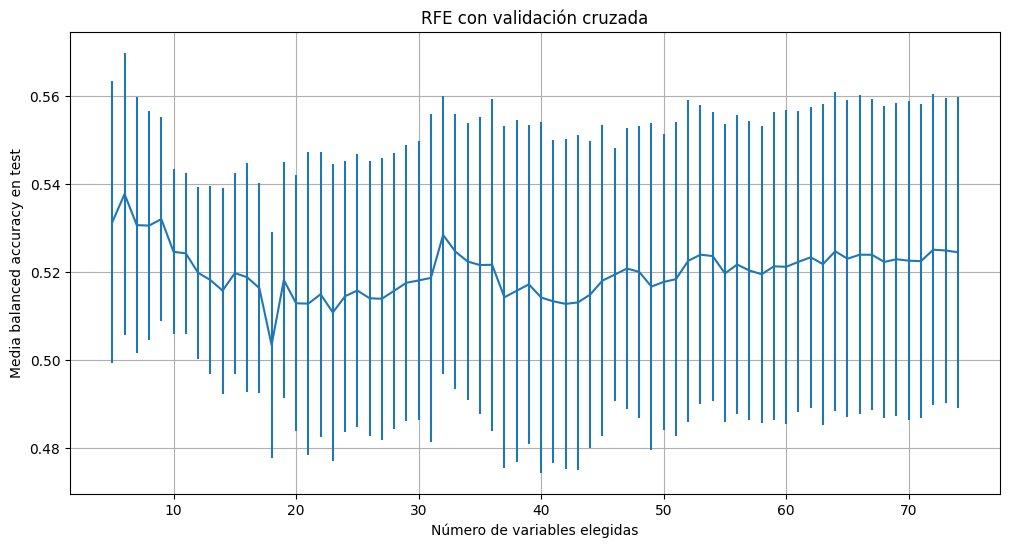

In [19]:
selected_features = aplicarRFECV(X_train, y_train)

# Filtrar columnas seleccionadas
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [20]:
# Crear pipeline: escalado + modelo
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Rejilla de hiperparámetros para el modelo dentro del pipeline
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],         # Regularización
    'clf__penalty': ['l1', 'l2'],              # Tipo de penalización
    'clf__solver': ['liblinear']              # 'liblinear' soporta l1 y l2
}

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='f1', n_jobs=-1)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-score (CV):", grid_search.best_score_)

Mejores hiperparámetros: {'clf__C': 100, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mejor F1-score (CV): 0.22189229681412853


In [21]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Obtener el mejor modelo
mejor_modelo = grid_search.best_estimator_

# Predecir en test
y_pred_test = mejor_modelo.predict(X_test)

# Evaluar rendimiento
print("\nF1-score en test:", f1_score(y_test, y_pred_test))
print("\nReporte de clasificación en test:\n", classification_report(y_test, y_pred_test))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred_test))


F1-score en test: 0.2484472049689441

Reporte de clasificación en test:
               precision    recall  f1-score   support

       False       0.55      0.83      0.66       288
        True       0.45      0.17      0.25       234

    accuracy                           0.54       522
   macro avg       0.50      0.50      0.46       522
weighted avg       0.51      0.54      0.48       522


Matriz de confusión:
 [[240  48]
 [194  40]]


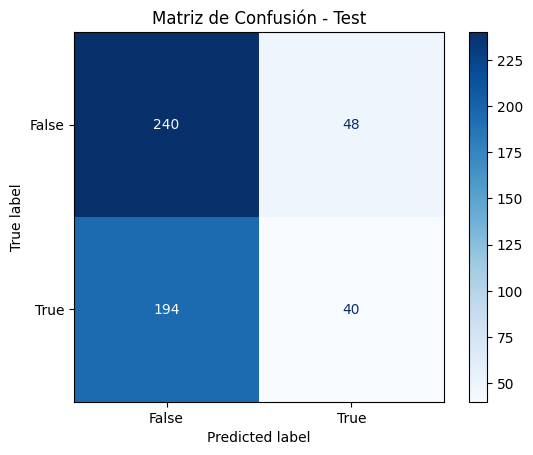

In [22]:
ConfusionMatrixDisplay.from_estimator(mejor_modelo, X_test, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Test")
plt.show()

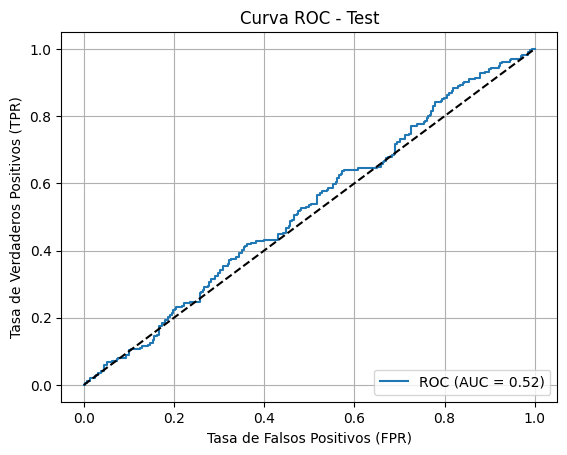

In [23]:
from sklearn.metrics import roc_curve, auc

# Asegurarse de que WINNER tenga solo 2 clases (por ejemplo, 0 y 1)
# Probabilidades de clase positiva (1)
y_scores = mejor_modelo.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Línea aleatoria
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Test')
plt.legend(loc='lower right')
plt.grid()
plt.show()

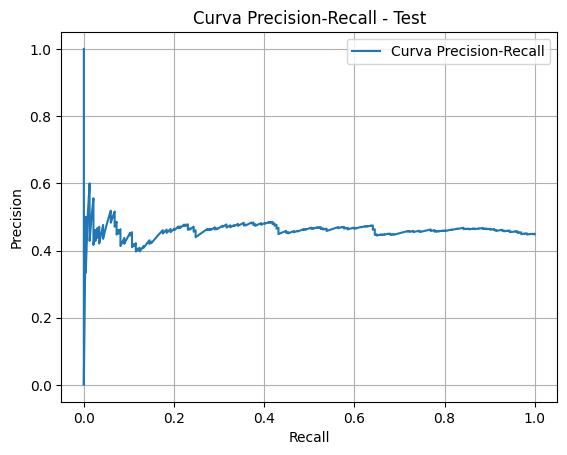

In [24]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, label="Curva Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Test")
plt.legend()
plt.grid()
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))

Accuracy: 0.5363984674329502
Precision: 0.45454545454545453
Recall: 0.17094017094017094
F1 Score: 0.2484472049689441
